In [1]:
# Data preparation
import pandas as pd
import numpy as np

# Plotting
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# Normalization and cosine distance
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

# Pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

import os

# Settings
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 8, 8

In [18]:
# Global variables
block_size = 32
feature_extractor = "ElasticFace"

# ----
import os
save_path_plot = f"./final_eval_{feature_extractor}_biometric_system_plt/"
filename_plot = f"arcface_pemiu{block_size}_performance.svg"
os.makedirs(save_path_plot, exist_ok=True)

In [19]:
df_genuine = pd.read_csv(f"../dataframes/elasticface/lfw_view2_genuine_pemiu{block_size}.csv", sep=",")
df_genuine

,Unnamed: 0,a_img,a_embedding_pemiu,b_img,b_embedding_pemiu,genuine,a_embedding_reconstructed,cos_sim_a_pemiu_a_pemiu_reconstructed
0,0,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/lfw_align_embeddings_elastic_pemiu32/A...,True,../data/lfw_align_embeddings_elastic_pemiu32_r...,0.564878
1,1,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic_pemiu32/A...,True,../data/lfw_align_embeddings_elastic_pemiu32_r...,0.821995
2,2,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic_pemiu32/A...,True,../data/lfw_align_embeddings_elastic_pemiu32_r...,0.728067
3,3,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/lfw_align_embeddings_elastic_pemiu32/A...,True,../data/lfw_align_embeddings_elastic_pemiu32_r...,0.507185
4,4,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/lfw_align_embeddings_elastic_pemiu32/A...,True,../data/lfw_align_embeddings_elastic_pemiu32_r...,0.665197
...,...,...,...,...,...,...,...,...
2995,5695,../data/lfw_align/Vladimir_Voltchkov/Vladimir_...,../data/lfw_align_embeddings_elastic_pemiu32/V...,../data/lfw_align/Vladimir_Voltchkov/Vladimir_...,../data/lfw_align_embeddings_elastic_pemiu32/V...,True,../data/lfw_align_embeddings_elastic_pemiu32_r...,0.461306
2996,5696,../data/lfw_align/Wang_Yi/Wang_Yi_0001.png,../data/lfw_align_embeddings_elastic_pemiu32/W...,../data/lfw_align/Wang_Yi/Wang_Yi_0002.png,../data/lfw_align_embeddings_elastic_pemiu32/W...,True,../data/lfw_align_embeddings_elastic_pemiu32_r...,0.698034
2997,5697,../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...,../data/lfw_align_embeddings_elastic_pemiu32/Z...,../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...,../data/lfw_align_embeddings_elastic_pemiu32/Z...,True,../data/lfw_align_embeddings_elastic_pemiu32_r...,0.683992
2998,5698,../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0001.png,../data/lfw_align_embeddings_elastic_pemiu32/Z...,../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0003.png,../data/lfw_align_embeddings_elastic_pemiu32/Z...,True,../data/lfw_align_embeddings_elastic_pemiu32_r...,0.728986


# Evaluation of biometric performance for PEMIU enhanced templates

Ingest dataframes containing path to LFW View 2 Target A and Target B for
- Original image
- PEMIU Shuffled embedding
- PEMIU Reconstructed embedding
- Block Size: See global variable above
- cos_sim between PEMIU Shuffled and Reconstructed embeddings

Add columns pointing to the unmodified embeddings. Reorder the columns for better readability.

In [20]:
df_genuine = pd.read_csv(f"../dataframes/elasticface/lfw_view2_genuine_pemiu{block_size}.csv", sep=",")
df_impostor = pd.read_csv(f"../dataframes/elasticface/lfw_view2_impostor_pemiu{block_size}.csv", sep=",")

# Add a column just containing the target name without extension
df_genuine['a_filename'] = df_genuine['a_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_genuine['b_filename'] = df_genuine['b_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_impostor['a_filename'] = df_impostor['a_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_impostor['b_filename'] = df_impostor['b_img'].apply(lambda x: x.split('/')[-1].split('.')[0])

# Add columns with path pointing to unmodified templates
path_unmodified = "../data/lfw_align_embeddings_elastic/"
df_genuine['a_embedding_unmodified'] = df_genuine['a_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_genuine['b_embedding_unmodified'] = df_genuine['b_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_impostor['a_embedding_unmodified'] = df_impostor['a_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_impostor['b_embedding_unmodified'] = df_impostor['b_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")


In [21]:
df_genuine.columns

Index(['Unnamed: 0', 'a_img', 'a_embedding_pemiu', 'b_img',
       'b_embedding_pemiu', 'genuine', 'a_embedding_reconstructed',
       'cos_sim_a_pemiu_a_pemiu_reconstructed', 'a_filename', 'b_filename',
       'a_embedding_unmodified', 'b_embedding_unmodified'],
      dtype='object')

In [22]:
# Rename index column
df_genuine = df_genuine.rename(columns = {"Unnamed: 0": "index"})
df_impostor = df_impostor.rename(columns = {"Unnamed: 0": "index"})

# Reorder columns
df_genuine = df_genuine[['index',
                         
                         'a_filename',
                         'a_img',
                         'a_embedding_unmodified',
                         'a_embedding_pemiu',
                         'a_embedding_reconstructed',
                         
                         'b_filename',
                         'b_img',
                         'b_embedding_unmodified',
                         'b_embedding_pemiu',
                         
                         'cos_sim_a_pemiu_a_pemiu_reconstructed',
                        ]]

# Reorder columns
df_impostor = df_impostor[['index',
                         
                         'a_filename',
                         'a_img',
                         'a_embedding_unmodified',
                         'a_embedding_pemiu',
                         'a_embedding_reconstructed',
                         
                         'b_filename',
                         'b_img',
                         'b_embedding_unmodified',
                         'b_embedding_pemiu',
                         
                         'cos_sim_a_pemiu_a_pemiu_reconstructed',
                        ]]

In [23]:
df_genuine

,index,a_filename,a_img,a_embedding_unmodified,a_embedding_pemiu,a_embedding_reconstructed,b_filename,b_img,b_embedding_unmodified,b_embedding_pemiu,cos_sim_a_pemiu_a_pemiu_reconstructed
0,0,Abel_Pacheco_0001,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/lfw_align_embeddings_elastic/Abel_Pach...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Abel_Pacheco_0004,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/lfw_align_embeddings_elastic/Abel_Pach...,../data/lfw_align_embeddings_elastic_pemiu32/A...,0.564878
1,1,Akhmed_Zakayev_0001,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic/Akhmed_Za...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Akhmed_Zakayev_0003,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic/Akhmed_Za...,../data/lfw_align_embeddings_elastic_pemiu32/A...,0.821995
2,2,Akhmed_Zakayev_0002,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic/Akhmed_Za...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Akhmed_Zakayev_0003,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic/Akhmed_Za...,../data/lfw_align_embeddings_elastic_pemiu32/A...,0.728067
3,3,Amber_Tamblyn_0001,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/lfw_align_embeddings_elastic/Amber_Tam...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Amber_Tamblyn_0002,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/lfw_align_embeddings_elastic/Amber_Tam...,../data/lfw_align_embeddings_elastic_pemiu32/A...,0.507185
4,4,Anders_Fogh_Rasmussen_0001,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/lfw_align_embeddings_elastic/Anders_Fo...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Anders_Fogh_Rasmussen_0003,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/lfw_align_embeddings_elastic/Anders_Fo...,../data/lfw_align_embeddings_elastic_pemiu32/A...,0.665197
...,...,...,...,...,...,...,...,...,...,...,...
2995,5695,Vladimir_Voltchkov_0001,../data/lfw_align/Vladimir_Voltchkov/Vladimir_...,../data/lfw_align_embeddings_elastic/Vladimir_...,../data/lfw_align_embeddings_elastic_pemiu32/V...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Vladimir_Voltchkov_0002,../data/lfw_align/Vladimir_Voltchkov/Vladimir_...,../data/lfw_align_embeddings_elastic/Vladimir_...,../data/lfw_align_embeddings_elastic_pemiu32/V...,0.461306
2996,5696,Wang_Yi_0001,../data/lfw_align/Wang_Yi/Wang_Yi_0001.png,../data/lfw_align_embeddings_elastic/Wang_Yi_0...,../data/lfw_align_embeddings_elastic_pemiu32/W...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Wang_Yi_0002,../data/lfw_align/Wang_Yi/Wang_Yi_0002.png,../data/lfw_align_embeddings_elastic/Wang_Yi_0...,../data/lfw_align_embeddings_elastic_pemiu32/W...,0.698034
2997,5697,Zafarullah_Khan_Jamali_0001,../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...,../data/lfw_align_embeddings_elastic/Zafarulla...,../data/lfw_align_embeddings_elastic_pemiu32/Z...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Zafarullah_Khan_Jamali_0002,../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...,../data/lfw_align_embeddings_elastic/Zafarulla...,../data/lfw_align_embeddings_elastic_pemiu32/Z...,0.683992
2998,5698,Zhu_Rongji_0001,../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0001.png,../data/lfw_align_embeddings_elastic/Zhu_Rongj...,../data/lfw_align_embeddings_elastic_pemiu32/Z...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Zhu_Rongji_0003,../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0003.png,../data/lfw_align_embeddings_elastic/Zhu_Rongj...,../data/lfw_align_embeddings_elastic_pemiu32/Z...,0.728986


## Calculate cos_sim

Calculate cosine similarity of
- target a / b embedding

In [24]:
# Cosine similarity according to Terhörst PEMIU implementation
def cos_sim(a, b):
    a, b = a.reshape(-1), b.reshape(-1)
    return np.dot(a,b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [25]:
# Load embeddings
genuine_a = df_genuine['a_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
genuine_b = df_genuine['b_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
impostor_a = df_impostor['a_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
impostor_b = df_impostor['b_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()

# Calculate cosine similarity using scipy spacial distance
df_genuine['cos_sim_a_b'] = [(cos_sim(x, y)) for x, y in zip(genuine_a, genuine_b)]
df_impostor['cos_sim_a_b'] = [(cos_sim(x, y)) for x, y in zip(impostor_a, impostor_b)]

## Plot

Visualize the distribution of genuine and impostor pairs for both unprotected and PEMIU enhanced templates on a normalized scale.

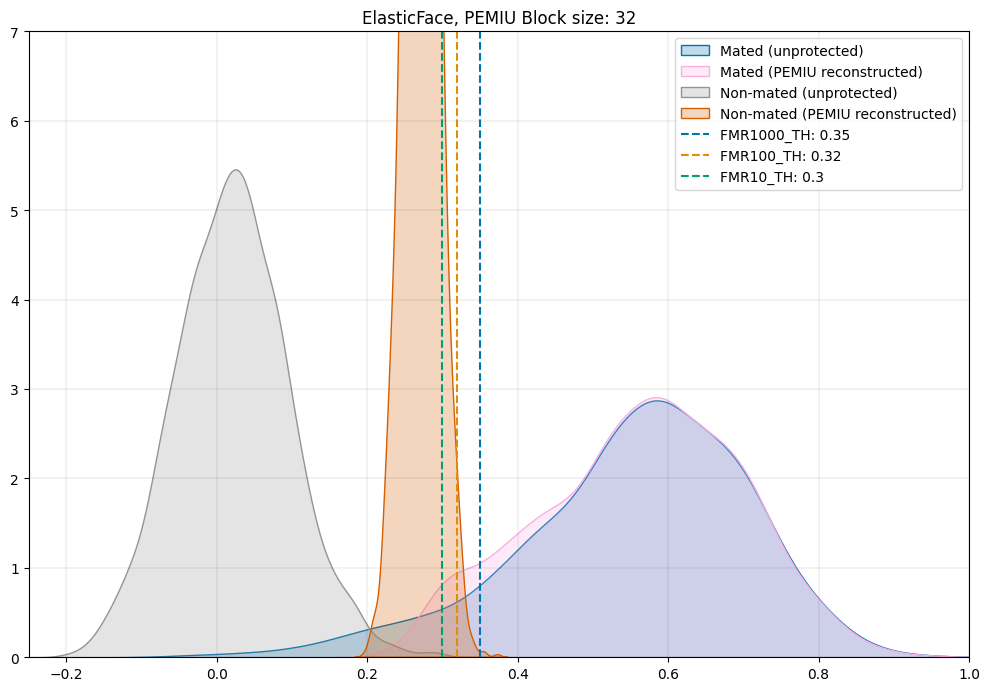

In [30]:
# Load df
df_pyeer = pd.read_csv(f"../evaluation/elasticface/pyeer_lfwview2_pemiu{block_size}_biometric_performance/eer_report.csv", 
                       sep=",", skiprows=[0])
df_pyeer.drop(df_pyeer.index[2:], inplace=True)

labels_th = ['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']
colors = ["b", "r", "g", "c"]

fig, ax = plt.subplots(1, 1,
                        figsize = (10, 7),
                        tight_layout = True)

# Comparison: Genuine and imnpostor
sns.kdeplot(df_genuine['cos_sim_a_b'], label="Mated (unprotected)", fill=True, color=sns.color_palette("colorblind")[0])
sns.kdeplot(df_genuine['cos_sim_a_pemiu_a_pemiu_reconstructed'], label="Mated (PEMIU reconstructed)", fill=True, color=sns.color_palette("colorblind")[6])

sns.kdeplot(df_impostor['cos_sim_a_b'], label="Non-mated (unprotected)", fill=True, color=sns.color_palette("colorblind")[7])
sns.kdeplot(df_impostor['cos_sim_a_pemiu_a_pemiu_reconstructed'], label="Non-mated (PEMIU reconstructed)", fill=True, color=sns.color_palette("colorblind")[3])
# Comparison: target a pemiu and target a pemiu reconstrcuted of genuine and impostor

# Thresholds
for index, column in enumerate(labels_th):
    ax.axvline(x = round(((df_pyeer[column][1])), 2), 
               color = sns.color_palette("colorblind")[index], 
               linestyle="--",
               label = f'{labels_th[index]}: {round(df_pyeer[column][1], 2)}')

ax.legend()
ax.set(xlabel="")
ax.set(ylabel="")
ax.set_title(f"{feature_extractor}, PEMIU Block size: {block_size}")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
plt.xlim([-0.25, 1])
plt.ylim([0, 7])
    
# Show plot
plt.savefig(f'{save_path_plot}{filename_plot}', bbox_inches='tight')
plt.show()

## Pyeer report

- tbd

In [27]:
stats_unprotected = get_eer_stats(
    df_genuine['cos_sim_a_b'],
    df_impostor['cos_sim_a_b'],
    ds_scores=False)
stats_genuine_pemiu_reconstructed = get_eer_stats(
    df_genuine['cos_sim_a_pemiu_a_pemiu_reconstructed'],
    df_impostor['cos_sim_a_pemiu_a_pemiu_reconstructed'],
    ds_scores=False)

In [28]:
save_path = f"../evaluation/elasticface/pyeer_lfwview2_pemiu{block_size}_biometric_performance/"
os.makedirs(save_path, exist_ok=True)
generate_eer_report([stats_unprotected,
                     stats_genuine_pemiu_reconstructed],
                    ['Unprotected',
                     'Genuine PEMIU Reconstructed'],
                    save_path + "eer_report.csv")

In [29]:
df_pyeer = pd.read_csv(f"../evaluation/elasticface/pyeer_lfwview2_pemiu{block_size}_biometric_performance_nonorm/eer_report.csv", 
                       sep=",", skiprows=[0])
df_pyeer.drop(df_pyeer.index[2:], inplace=True)
df_pyeer.T

,0,1
Experiment ID,Unprotected,Genuine PEMIU Reconstructed
GMean,0.553969,0.563022
GSTD,0.153647,0.134818
IMean,0.020854,0.271923
ISTD,0.074243,0.022386
Sensitivity index (d'),4.418202,3.012319
AUC,0.995609,0.987996
J-Index,0.962333,0.936
J-Index_TH,0.195642,0.330296
MCC,0.962472,0.937402


In [13]:
labels = ["TMR Zero\t\t", "TMR 1000 (10^3)\t\t", "TMR  100 (10^2)\t\t", "TMR   10\t\t"]

for i, title in enumerate(['Bona Fide Comparison Unprotected', 
                           f'Bona Fide Comparison PEMIU Protected (block size {block_size})']):
    print(f"\n{title}")
    for index, row in enumerate(df_pyeer[['ZeroFMR', 'FMR1000', 'FMR100', 'FMR10']]):
        print(f"{labels[index]}: {round(((1 - (df_pyeer[row].values[i])) * 100), 2)} %")


Bona Fide Comparison Unprotected
TMR Zero		: 93.37 %
TMR 1000 (10^3)		: 93.67 %
TMR  100 (10^2)		: 97.07 %
TMR   10		: 99.07 %

Bona Fide Comparison PEMIU Protected (block size 32)
TMR Zero		: 89.6 %
TMR 1000 (10^3)		: 92.47 %
TMR  100 (10^2)		: 94.5 %
TMR   10		: 97.13 %


In [16]:
df_genuine.head()

,index,a_filename,a_img,a_embedding_unmodified,a_embedding_pemiu,a_embedding_reconstructed,b_filename,b_img,b_embedding_unmodified,b_embedding_pemiu,cos_sim_a_pemiu_a_pemiu_reconstructed,cos_sim_a_b,cos_sim_a_pemiu_a_pemiu_reconstructed_normalized,cos_sim_a_b_normalized
0,0,Abel_Pacheco_0001,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/lfw_align_embeddings_elastic/Abel_Pach...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Abel_Pacheco_0004,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/lfw_align_embeddings_elastic/Abel_Pach...,../data/lfw_align_embeddings_elastic_pemiu32/A...,0.564878,0.564878,0.654869,0.654869
1,1,Akhmed_Zakayev_0001,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic/Akhmed_Za...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Akhmed_Zakayev_0003,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic/Akhmed_Za...,../data/lfw_align_embeddings_elastic_pemiu32/A...,0.821995,0.821995,0.875293,0.875293
2,2,Akhmed_Zakayev_0002,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic/Akhmed_Za...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Akhmed_Zakayev_0003,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/lfw_align_embeddings_elastic/Akhmed_Za...,../data/lfw_align_embeddings_elastic_pemiu32/A...,0.728067,0.728067,0.794770,0.794770
3,3,Amber_Tamblyn_0001,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/lfw_align_embeddings_elastic/Amber_Tam...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Amber_Tamblyn_0002,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/lfw_align_embeddings_elastic/Amber_Tam...,../data/lfw_align_embeddings_elastic_pemiu32/A...,0.507185,0.507185,0.605410,0.605410
4,4,Anders_Fogh_Rasmussen_0001,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/lfw_align_embeddings_elastic/Anders_Fo...,../data/lfw_align_embeddings_elastic_pemiu32/A...,../data/lfw_align_embeddings_elastic_pemiu32_r...,Anders_Fogh_Rasmussen_0003,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/lfw_align_embeddings_elastic/Anders_Fo...,../data/lfw_align_embeddings_elastic_pemiu32/A...,0.665197,0.665197,0.740872,0.740872
